In [18]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math



In [6]:
df = pd.read_csv("sap_stock.csv", parse_dates=["Date"], index_col=["Date"], dayfirst=True)
df.head(5)

,Open,High,Low,Close,Change,Traded Volume,Turnover,Last Price of the Day,Daily Traded Units,Daily Turnover
Date,,,,,,,,,,
2009-03-09,25.16,25.82,24.48,25.59,NaN,5749357.0,145200289.0,NaN,NaN,NaN
2009-03-10,25.68,26.95,25.68,26.87,NaN,7507770.0,198480965.0,NaN,NaN,NaN
2009-03-11,26.50,26.95,26.26,26.64,NaN,5855095.0,155815439.0,NaN,NaN,NaN
2009-03-12,26.15,26.47,25.82,26.18,NaN,6294955.0,164489409.0,NaN,NaN,NaN
2009-03-13,26.01,26.24,25.65,25.73,NaN,6814568.0,176228331.0,NaN,NaN,NaN


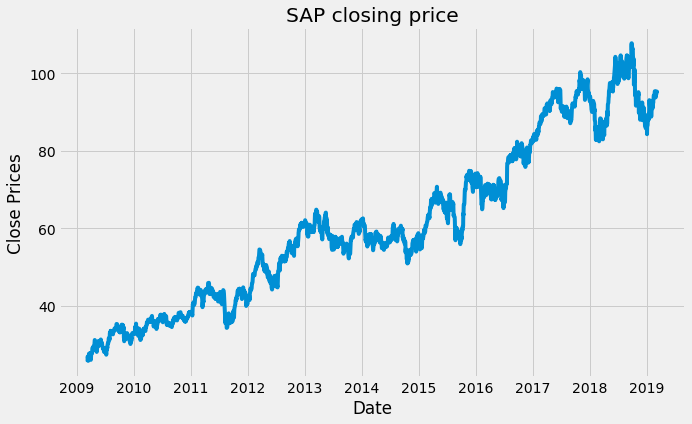

In [8]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df.Close)
plt.title('SAP closing price')
plt.show()

<AxesSubplot:ylabel='Density'>

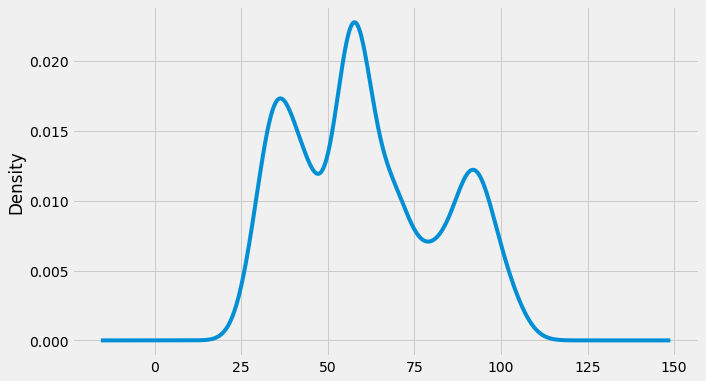

In [10]:
df.Close.plot(kind='kde')

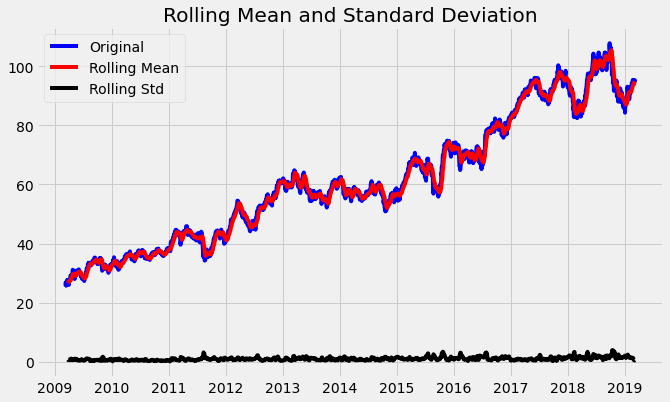

Results of dickey fuller test
Test Statistics                  -0.987251
p-value                           0.757886
No. of lags used                  0.000000
Number of observations used    2549.000000
critical value (1%)              -3.432918
critical value (5%)              -2.862675
critical value (10%)             -2.567374
dtype: float64


In [11]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df.Close)

<Figure size 720x432 with 0 Axes>

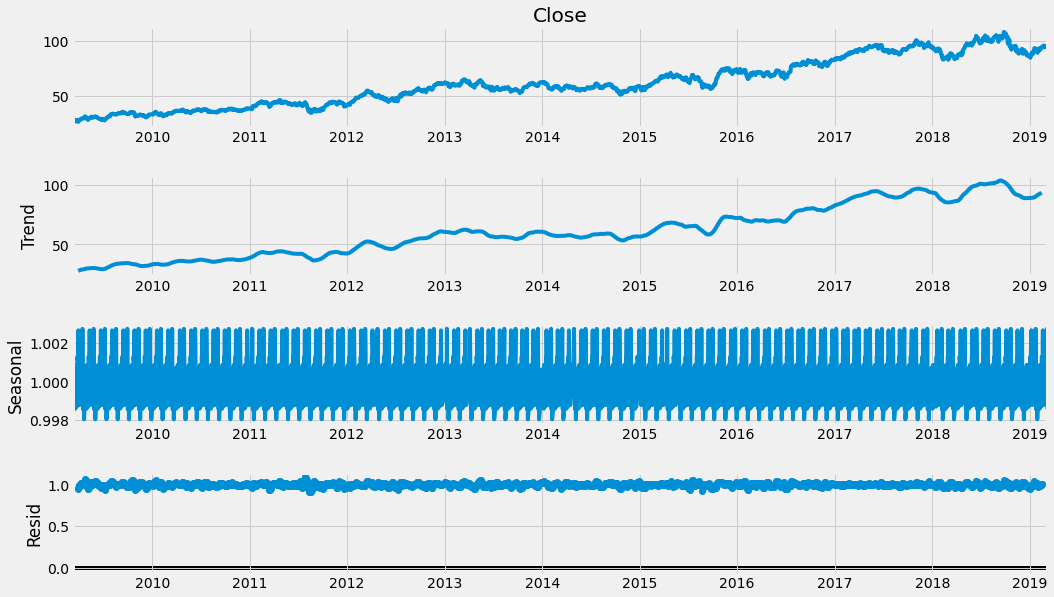

In [99]:
result = seasonal_decompose(df.Close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


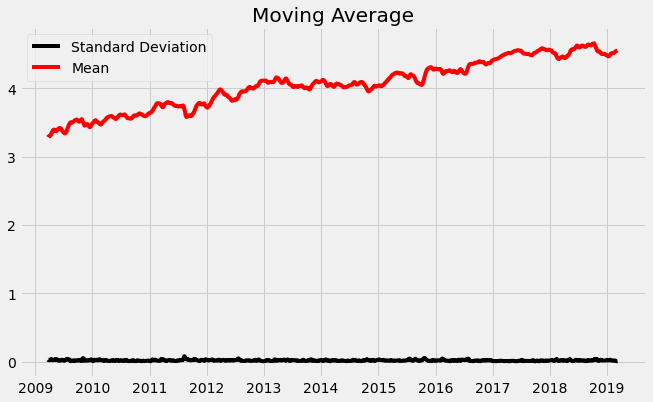

In [14]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams

rcParams['figure.figsize'] = 10, 6
df_log = np.log(df.Close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

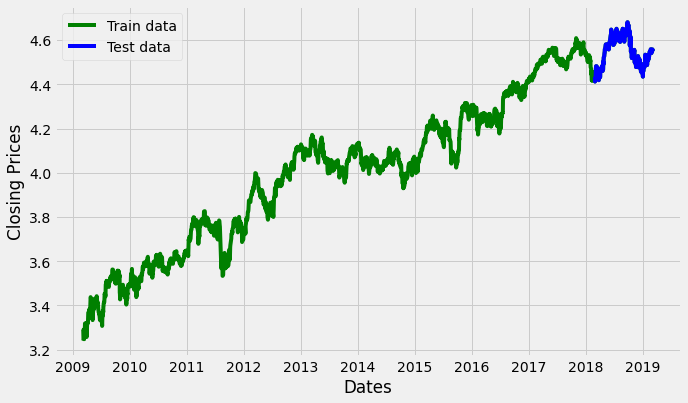

In [15]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

<Figure size 720x432 with 0 Axes>

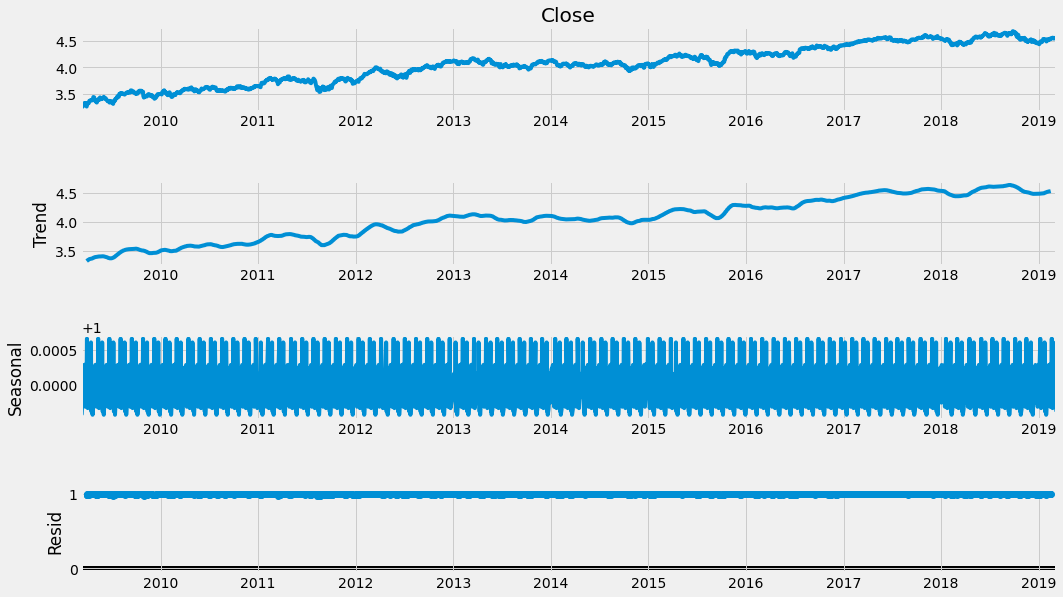

In [85]:
result = seasonal_decompose(df_log, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12869.483, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-13435.251, Time=0.53 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.72 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-13433.337, Time=0.68 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.78 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-13434.499, Time=0.34 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 4.344 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2292
Model:               SARIMAX(1, 0, 1)   Log Likelihood                6720.626
Date: 

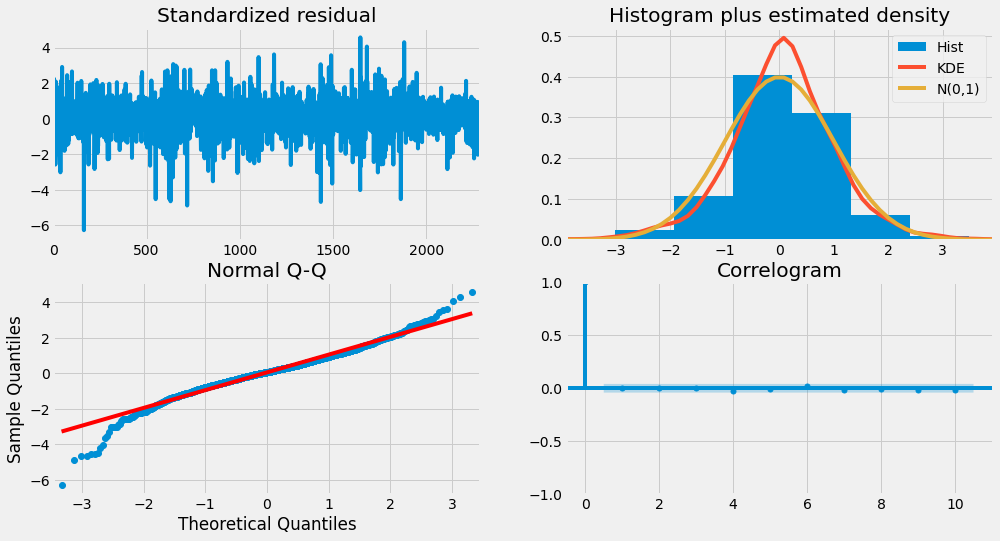

In [16]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

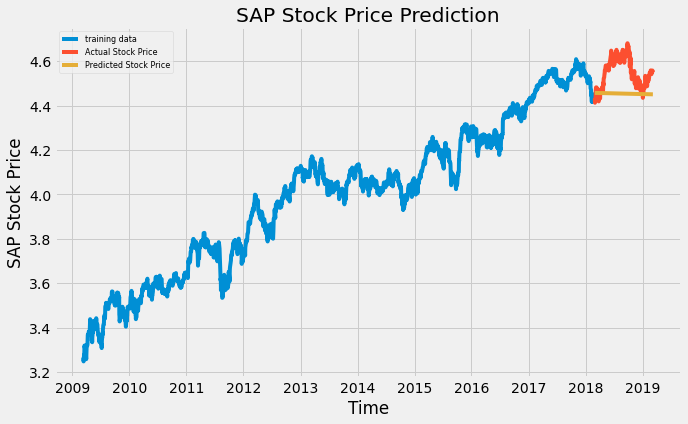

In [98]:
forecast = model_autoARIMA.predict(n_periods=len(test_data))
forecast = pd.DataFrame(forecast, index=test_data.index, columns=["Prediction"])

plt.plot(train_data, label='training data')
plt.plot(test_data, label='Actual Stock Price')
plt.plot(forecast, label='Predicted Stock Price')
plt.title('SAP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SAP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [87]:
# report performance
mse = mean_squared_error(test_data.values, forecast.values)
print('MSE: '+str(mse))

mae = mean_absolute_error(test_data.values, forecast.values)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(test_data.values, forecast.values))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(forecast.values - test_data.values)/np.abs(test_data.values))
print('MAPE: '+str(mape))

MSE: 0.013962485321275626
MAE: 0.10098911729381853
RMSE: 0.1181629608687749
MAPE: 0.02193036313279933
